<a href="https://colab.research.google.com/github/aldysp34/Music-Classification-and-Recommendation/blob/master/music_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Machine Learning Klasfikasi dan Sistem Rekomendasi Musik**
_Oleh :_
1. *M299R5310 - Muhammad Aldi Surya Putra*
2. *M014V6060 - Ayu Kadek Nadya Oktaviana*

## **1. Download Dataset**

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od 
od.download("https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification")

Skipping, found downloaded files in "./gtzan-dataset-music-genre-classification" (use force=True to force download)


## **2. Import Library**

In [ ]:
# Usual Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import scipy
import os
import pickle

# Audio Library
import librosa
import librosa.display
import IPython.display as ipd

# Classification Library
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import normalize
import tensorflow as tf
from tensorflow import keras

# Warning Ignore
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Inisialisasi Path Dataset
general_path = '/content/gtzan-dataset-music-genre-classification/Data'

# List Genre Dataset
print(list(os.listdir(f'{general_path}/genres_original/')))

['country', 'disco', 'hiphop', 'blues', 'classical', 'pop', 'rock', 'reggae', 'jazz', 'metal']


## **3. Explore Data Audio**

In [ ]:
# Analisis satu sampel audio
data , sr = librosa.load(f'{general_path}/genres_original/pop/pop.00096.wav', sr = 45600)

# Cek tipe data
print(type(data), type(sr))

<class 'numpy.ndarray'> <class 'int'>


In [ ]:
# Keterangan audio
print('Data\t\t\t: ', data)
print('Data Shape\t\t: ', np.shape(data))
print('Sample Rate (KHz)\t: ', sr)

# Panjang audio
print('\nPanjang Audio\t\t:', 1368009/45600)

Data			:  [0.24890843 0.28354958 0.24970092 ... 0.48826233 0.2572244  0.        ]
Data Shape		:  (1368009,)
Sample Rate (KHz)	:  45600

Panjang Audio		: 30.000197368421052


In [ ]:
# Memutar audio
ipd.Audio(data, rate=sr)

### **3.1 _Audio Representation_**

#### **1. Sound Waves**

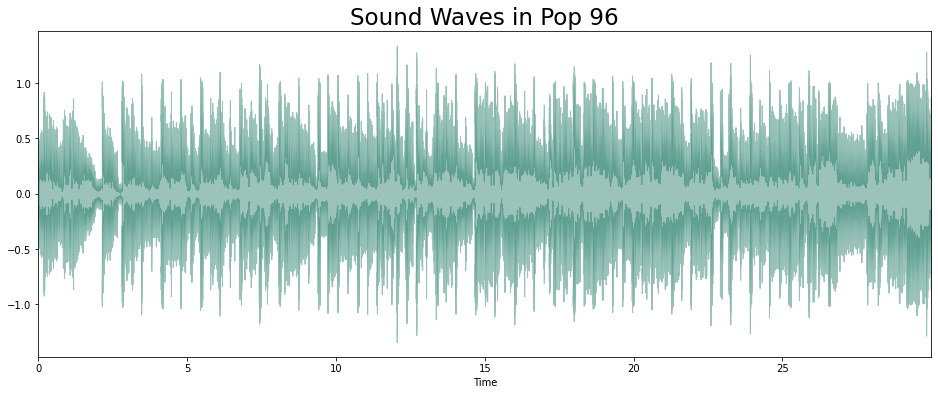

In [ ]:
# Waveform Audio
plt.figure(figsize = (16, 6))
librosa.display.waveplot(y = data, sr = sr, alpha = 0.4, color = "#066B54");
plt.title("Sound Waves in Pop 96", fontsize = 23);

#### **2. Spectogram**

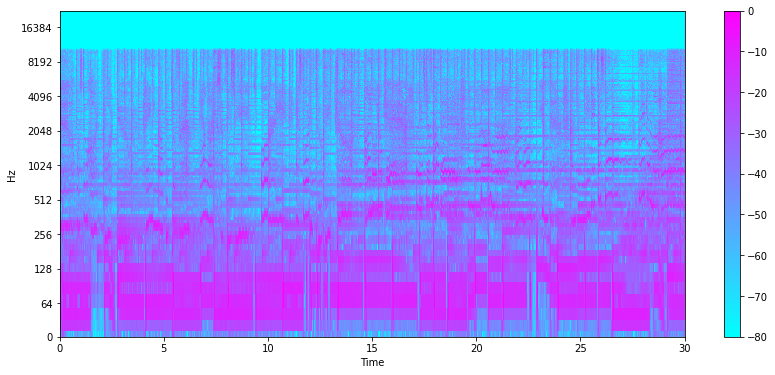

In [ ]:
# Short-time Fourier Transform (STFT)
X = librosa.stft(data)

# Konversi amplitude spectogram menjadi Decibels-scaled spectogram
Xdb = librosa.amplitude_to_db(X, ref = np.max)

# Menampilkan spectogram
plt.figure(figsize = (14, 6))
librosa.display.specshow(Xdb, sr = sr, x_axis = 'time', y_axis = 'log', cmap ='cool')

plt.colorbar()

#### **3. Mel Spectogram**

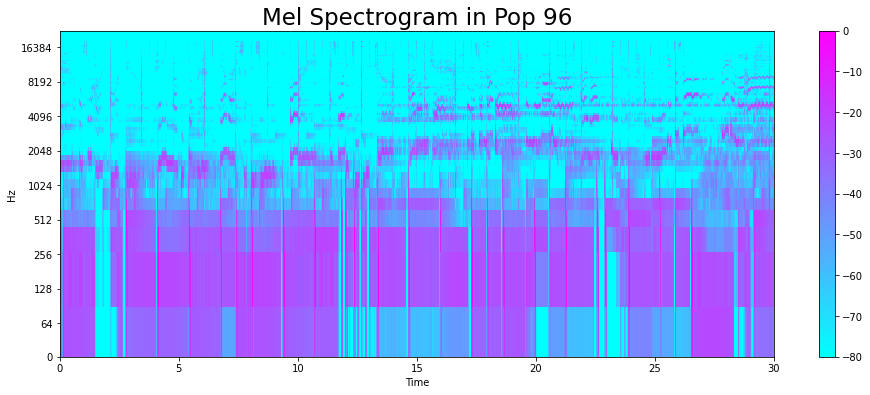

In [ ]:
# Konversi mel spectogram
M = librosa.feature.melspectrogram(data, sr = sr)
M_Xdb = librosa.amplitude_to_db(M, ref = np.max)

# Menampilkan Mel Spectogram
plt.figure(figsize = (16, 6))
librosa.display.specshow(M_Xdb, sr = sr, x_axis = 'time', y_axis = 'log', cmap = 'cool');

plt.colorbar();
plt.title("Mel Spectrogram in Pop 96", fontsize = 23);

### **3.2 _Audio Features_**

#### **1. Tempo BMP (Beats Per Minute)**

In [ ]:
# Tempo BPM
tempo, _ = librosa.beat.beat_track(data, sr = sr)
tempo

90.57203389830508

#### **2. Spectral Centroid**

In [ ]:
# Menghitung Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(data, sr = sr)[0]

# Bentuk vektor dari Spectral Centroids
print('Centroids\t\t\t:', spectral_centroids)
print('Shape of Spectral Centroids\t:', spectral_centroids.shape)

# Menghitung variabel time untuk visualisasi
frames = range(len(spectral_centroids))

# Konversi frame to time (seconds)
time = librosa.frames_to_time(frames)

print('Frames\t\t\t\t:', frames)
print('Time\t\t\t\t:', time)

# Function untuk normalisasi data audio
def normalize(x, axis = 0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

Centroids			: [2531.47417555 2416.76987655 2430.18312467 ... 2661.66384706 2946.42301581
 3412.88910055]
Shape of Spectral Centroids	: (2672,)
Frames				: range(0, 2672)
Time				: [0.00000000e+00 2.32199546e-02 4.64399093e-02 ... 6.19740590e+01
 6.19972789e+01 6.20204989e+01]


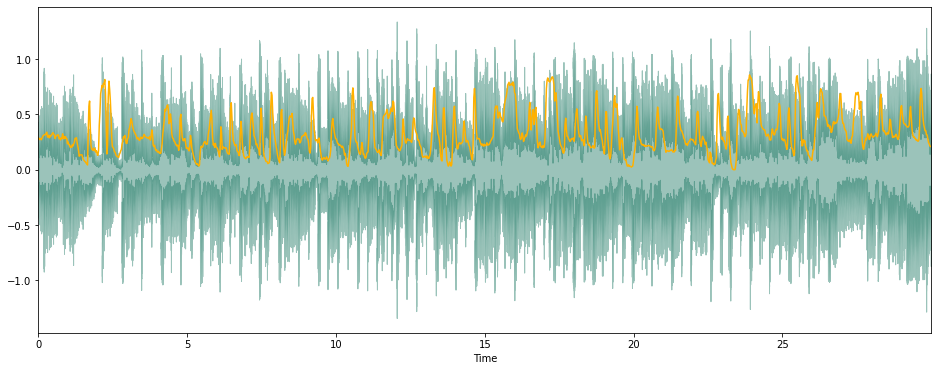

In [ ]:
# Visualiasi Spectral Centroid
plt.figure(figsize = (16, 6))
librosa.display.waveplot(data, sr=sr, alpha=0.4, color = "#066B54");
plt.plot(time, normalize(spectral_centroids), color='#FFB100');

#### **3. Spectral Rolloff**

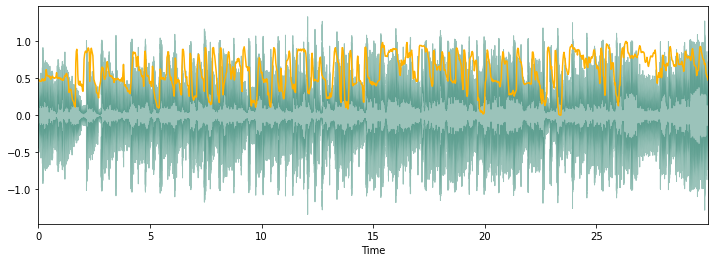

In [ ]:
# Spectral Rolloff vector
spectral_rolloff = librosa.feature.spectral_rolloff(data, sr = sr)[0]

# Menampilkan Spectral Rolloff
plt.figure(figsize = (12, 4))
librosa.display.waveplot(data, sr = sr, alpha = 0.4, color = "#066B54")
plt.plot(time, normalize(spectral_rolloff), color='#FFB100');

#### **4. Mel-Frequency Cepstral Coefficients**

MFCC Shape	: (20, 2672)


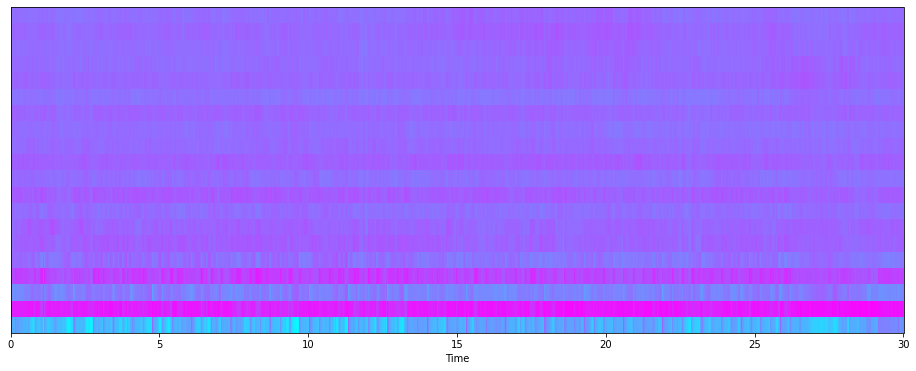

In [ ]:
# Konversi ke MFCC
mfccs = librosa.feature.mfcc(data, sr = sr)
print('MFCC Shape\t:', mfccs.shape)

# Menampilkan MFCCs
plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr = sr, x_axis = 'time', cmap = 'cool');

Mean	: 1.142125e-09
Var	: 1.0


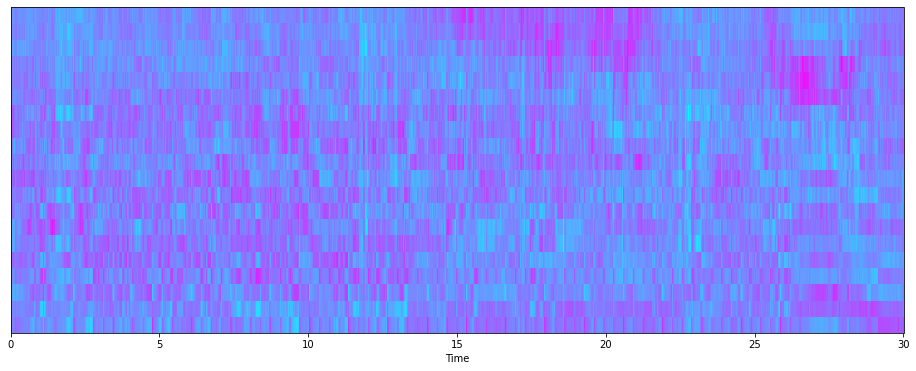

In [ ]:
# Lakukan Feature Scaling
mfccs = sklearn.preprocessing.scale(mfccs, axis=1)
print('Mean\t:', mfccs.mean())
print('Var\t:', mfccs.var())

plt.figure(figsize = (16, 6))
librosa.display.specshow(mfccs, sr = sr, x_axis = 'time', cmap = 'cool');

#### **5. Chroma Feature**

Chromagram Shape	: (12, 2672)


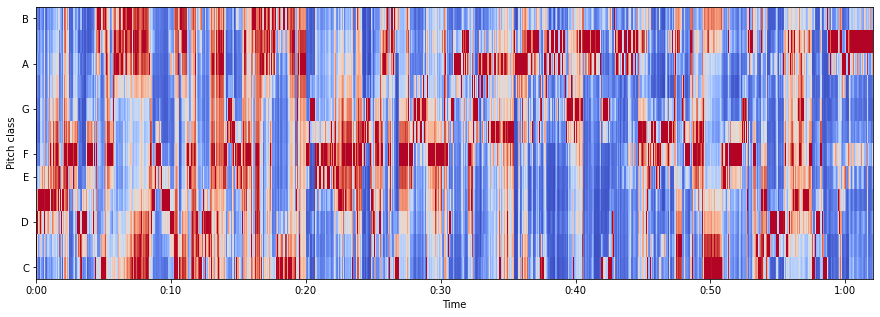

In [ ]:
# Chromogram
chromagram = librosa.feature.chroma_stft(data, sr = sr)
print('Chromagram Shape\t:', chromagram.shape)

# Menampilkan Chromagram
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram, x_axis = 'time', y_axis = 'chroma', cmap = 'coolwarm')

## **4. Exploratory Data Analysis**

### **4.1 Data Understanding**

In [ ]:
# Read data
df = pd.read_csv(f'{general_path}/features_30_sec.csv')
df.head()

filename  length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var  label
0  blues.00000.wav  661794          0.350088  ...     1.221291   46.936035  blues
1  blues.00001.wav  661794          0.340914  ...     0.531217   45.786282  blues
2  blues.00002.wav  661794          0.363637  ...    -2.231258   30.573025  blues
3  blues.00003.wav  661794          0.404785  ...    -3.407448   31.949339  blues
4  blues.00004.wav  661794          0.308526  ...   -11.703234   55.195160  blues

[5 rows x 60 columns]

In [ ]:
# Informasi kolom pada dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 1000 non-null   object 
 1   length                   1000 non-null   int64  
 2   chroma_stft_mean         1000 non-null   float64
 3   chroma_stft_var          1000 non-null   float64
 4   rms_mean                 1000 non-null   float64
 5   rms_var                  1000 non-null   float64
 6   spectral_centroid_mean   1000 non-null   float64
 7   spectral_centroid_var    1000 non-null   float64
 8   spectral_bandwidth_mean  1000 non-null   float64
 9   spectral_bandwidth_var   1000 non-null   float64
 10  rolloff_mean             1000 non-null   float64
 11  rolloff_var              1000 non-null   float64
 12  zero_crossing_rate_mean  1000 non-null   float64
 13  zero_crossing_rate_var   1000 non-null   float64
 14  harmony_mean             

### **4.2 Corelation Heatmap**

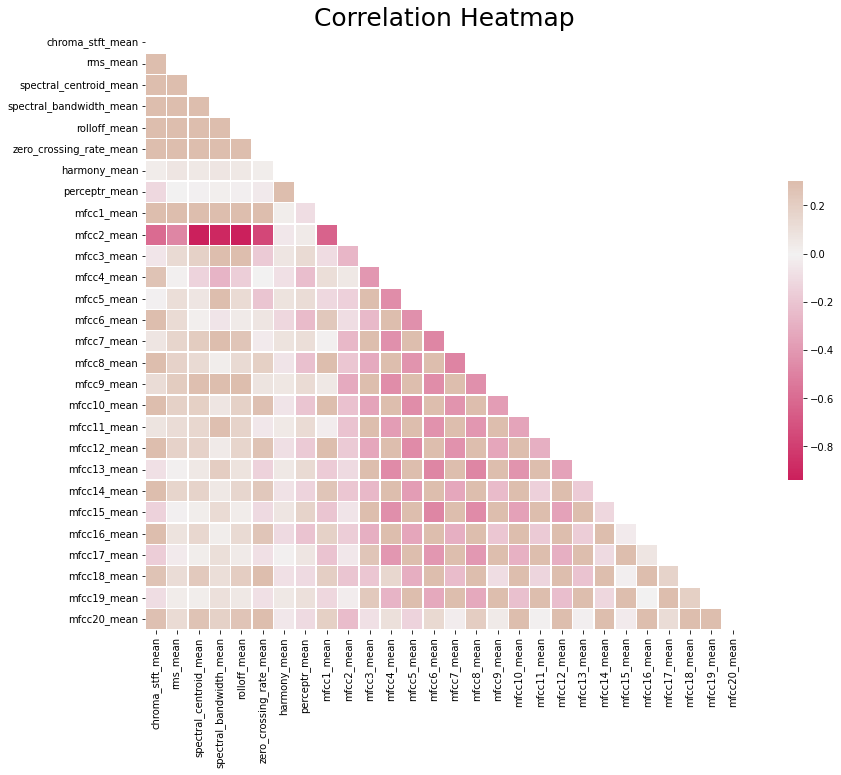

In [ ]:
# Menghitung Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Menampilkan data sebagai segitiga atas
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(16, 11));

# Mengatur diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Menampilkan Corelation Heatmap
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap', fontsize = 25)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

### **4.3 Box Plot untuk Distribusi Genre**

Text(0, 0.5, 'BPM')

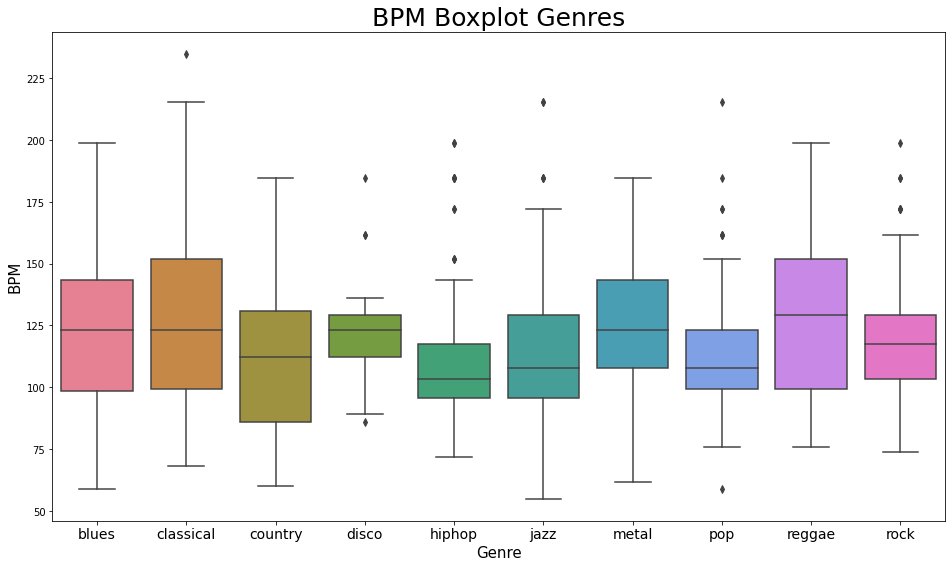

In [ ]:
# Box-Plot Genre
x = df[["label", "tempo"]]

f, ax = plt.subplots(figsize=(16, 9));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot Genres', fontsize = 25)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)

## **5. Klasifikasi Genre**